In [1]:
#import libraries
import pandas as pd
import numpy as np
import time
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
import ssl
import re
import sklearn
from sklearn import feature_selection, feature_extraction, naive_bayes, pipeline, metrics

#SSL error fix
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#download corpuses
nltk.download('stopwords')
nltk.download('omw-1.4')

#command to install pip packages in jupyter
#!{sys.executable} -m pip install [package]


/home/riku/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/riku/snap/jupyter/6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/riku/snap/jupyter/6/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
#load data using only 'subreddit' and 'body' features
start = time.process_time()
cols = ['subreddit', 'body ']
df = pd.read_csv('politics25.tsv', nrows=20000000, sep='\t', usecols=cols)
df = df.dropna()
end = time.process_time()
print(end-start)

120.70576120900002


In [16]:
a = [1,2,3]
b = [3,4,5]
a + b

[1, 2, 3, 3, 4, 5]

In [3]:
#preprocessing
df = df.rename(columns={'body ':'body'})

#drop nontrivial subreddits
far_left = ['chapotraphouse', 'anarchism', 'completeanarchy']
drops = ['antiwork', 'keep_track', 'jordanpeterson','political_revolution',
         'esist', 'politics', 'politicalhumor', 'anarcho_capitalism', 'cringeanarchy',
         'selfawarewolves', 'the_mueller' , 'onguardforthee']
drops = far_left + drops
df = df[~df.subreddit.isin(drops)]

#find large (>100 0000 posts) subreddits 
large_subreddits = df['subreddit'].value_counts()[df['subreddit']
                    .value_counts()>100000].index.tolist()

#drop large subreddits
df_small = df[~df.subreddit.isin(large_subreddits)]

#sample large subreddits to 100 000 posts
for sub in large_subreddits:
    sample = df[df.subreddit == sub].sample(100000)
    df_small = df_small.append(sample)
    
#rename column
df_small = df.rename(columns={'subreddit': 'spectrum'})
    
#rename subreddits based on political spectrum
left = ['liberal', 'wayofthebern', 'ourpresident', 'libertarian',
        'sandersforpresident', 'socialism', 'latestagecapitalism',
        'fullcommunism', 'communism', 'neoliberal', 'goldandblack',
        'progressive', 'latestagesocialism']
right = ['conservative', 'republican', 'the_donald', 'thenewright']

df_small['spectrum'] = df_small['spectrum'].replace(left, 'left')
df_small['spectrum'] = df_small['spectrum'].replace(right, 'right')

#sample spectrums
df_spectrum = pd.DataFrame()
for spec in ['left', 'right']:
    sample = df_small[df_small.spectrum == spec].sample(100000)
    df_spectrum = df_spectrum.append(sample)

#empty df to free memory
df = pd.DataFrame()

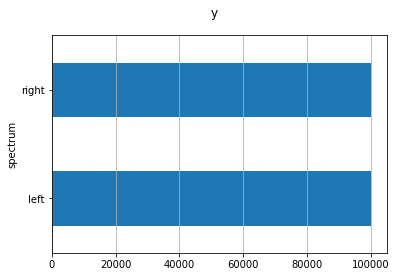

In [4]:
#show distribution of data
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_spectrum["spectrum"].reset_index().groupby("spectrum").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

<font size="7">TF-IDF</font>

In [5]:
#preprocessing function
def preprocess(text, stemm=False, lemm=True, stopwords=None):
    
    #clean
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    #tokenize and remove stopwords
    lst_text = text.split()
    if stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords]
                
    #if stemming
    if stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # if lemmatise
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # return string
    text = " ".join(lst_text)
    return text

In [6]:
#define stopwords
stopwords = nltk.corpus.stopwords.words("english")

#process text
start = time.process_time()
df_spectrum['body'] = df_spectrum['body'].apply(lambda x: 
                preprocess(x, stemm=False, lemm=True,
                stopwords=stopwords))
end = time.process_time()
print(end-start)

43.53325932300001


In [7]:
#save processed data to speed up future computations
df_spectrum.to_csv('spectrum.csv')

#load preprocessed data
#df_spectrum = pd.read_csv('spectrum.csv')
#df_spectrum = df_spectrum.dropna()

In [8]:
#create TF-IDF
start = time.process_time()

#split data 
train, test = sklearn.model_selection.train_test_split(df_spectrum, test_size=0.3)

#target
y_train = train['spectrum'].values
y_test = test['spectrum'].values

#Tf-idf
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

#feature matrix
vectorizer.fit(train['body'])
X_train = vectorizer.transform(train['body'])
vocab = vectorizer.vocabulary_

end = time.process_time()
print(end-start)

19.144410467


In [11]:
#classifier
start = time.process_time()
classifier = naive_bayes.MultinomialNB()
#classifier = KMeans(n_clusters=2).fit(X_train)

#pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
#train classifier
model["classifier"].fit(X_train, y_train)

#test
X_test = test["body"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

end = time.process_time()
print(end-start)

5.956543463999992


Accuracy: 0.7
Auc: 0.79
Detail:
              precision    recall  f1-score   support

        left       0.70      0.71      0.70     29884
       right       0.71      0.70      0.70     30116

    accuracy                           0.70     60000
   macro avg       0.70      0.70      0.70     60000
weighted avg       0.70      0.70      0.70     60000

0.12393867438894009


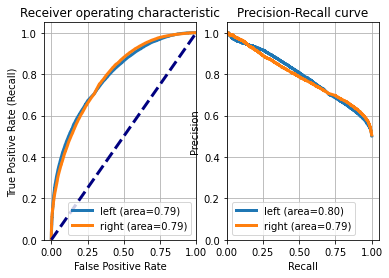

In [15]:
#print results

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
                            #multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
#NMI score with geometric average as in Strehl and Ghosh
print(metrics.normalized_mutual_info_score(y_test, predicted, average_method='geometric'))


fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()